In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




In [2]:
data = pd.read_csv("nhis.csv")
print(data.head())
print(data.shape)

   Unnamed: 0  YEAR           NHISPID  AGE  SEX  SEXORIEN  MARSTAT  BIRTHYR  \
0     2744230  1986  1986109602890101   60    1       NaN       11      NaN   
1     2744231  1986  1986109602890102   54    2       NaN       11      NaN   
2     2744232  1986  1986109602890103   21    1       NaN       50      NaN   
3     2744233  1986  1986109602890201   46    1       NaN       11      NaN   
4     2744234  1986  1986109602890202   38    2       NaN       11      NaN   

   MORTSTAT  MORTDODY  
0       1.0    2005.0  
1       1.0    2010.0  
2       2.0    9999.0  
3       2.0    9999.0  
4       2.0    9999.0  
(1605246, 10)


In [10]:
# Dropping cases where birth year is not known
data2 =data[(data["BIRTHYR"]<=2009) & (data["BIRTHYR"].notnull())]
data2 = pd.DataFrame(data2)

# Calculating time-to-event
data2["Longevity"]= data2["MORTDODY"] - data2["BIRTHYR"]

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"]=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead']==0,"Longevity"] = 2009 -data2.loc[data2['dead']==0,"BIRTHYR"] 

#Setting the age limit at 75 and limiting the dataset to married and unmarried.
data3 = pd.DataFrame(data2[data2['MARSTAT'].isin(range(10,51))])
data3 = pd.DataFrame(data2[data2['Longevity']<=75])
data3 = pd.DataFrame(data3)
data3.head()


,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead
829402,3928174,1997,19970003080101,33,2,NaN,11,1963.0,2.0,9999.0,46.0,0.0
829403,3928175,1997,19970003080102,36,1,NaN,11,1960.0,2.0,9999.0,49.0,0.0
829404,3928178,1997,19970003090101,42,1,NaN,11,1954.0,1.0,1999.0,45.0,1.0
829405,3928179,1997,19970003090102,52,2,NaN,11,1944.0,2.0,9999.0,65.0,0.0
829407,3928182,1997,19970003100101,41,1,NaN,11,1955.0,2.0,9999.0,54.0,0.0


In [11]:
 #Creating a binary variable where 1 = married
data3['married'] = np.where(data3['MARSTAT']<12,1,0)

In [12]:
data3['married'].value_counts()

1    386712
0    279343
Name: married, dtype: int64

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sf = sm.SurvfuncRight(data3["Longevity"], data3["dead"])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,666053,2.0
19.0,0.999979,0.000006,665275,12.0
20.0,0.999932,0.000010,663747,31.0
21.0,0.999863,0.000014,661250,46.0
22.0,0.999802,0.000017,658005,40.0


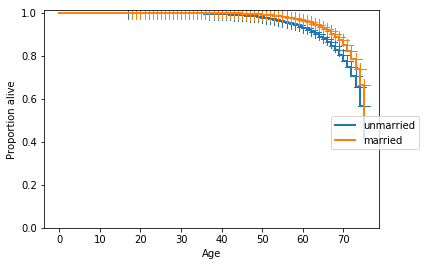

In [14]:
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data3.groupby("married")

ax = plt.axes()
status = ["unmarried","married"]
# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), status, "center right")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)




In [15]:
#run model
mod = smf.phreg("Longevity ~  married", # model name
                data3, # the data
                status=data3['dead'].values # right-censored columns
                ) 
rslt = mod.fit()
print(rslt.summary())

                        Results: PHReg
Model:                   PH Reg        Sample size:     666053
Dependent variable:      Longevity     Num. events:     30937 
Ties:                    Breslow                              
--------------------------------------------------------------
         log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
--------------------------------------------------------------
married -0.4897    0.0115 0.6128 -42.7341 0.0000 0.5992 0.6267
Confidence intervals are for the hazard ratios


According to the model, married people under 75 are 61% less likely to die.

        Unnamed: 0  YEAR         NHISPID  AGE  SEX  SEXORIEN  MARSTAT  \
829402     3928174  1997  19970003080101   33    2       NaN       11   
829403     3928175  1997  19970003080102   36    1       NaN       11   
829404     3928178  1997  19970003090101   42    1       NaN       11   
829405     3928179  1997  19970003090102   52    2       NaN       11   
829407     3928182  1997  19970003100101   41    1       NaN       11   

        BIRTHYR  MORTSTAT  MORTDODY  Longevity  dead  married  
829402   1963.0       2.0    9999.0       46.0   0.0        1  
829403   1960.0       2.0    9999.0       49.0   0.0        1  
829404   1954.0       1.0    1999.0       45.0   1.0        1  
829405   1944.0       2.0    9999.0       65.0   0.0        1  
829407   1955.0       2.0    9999.0       54.0   0.0        1  


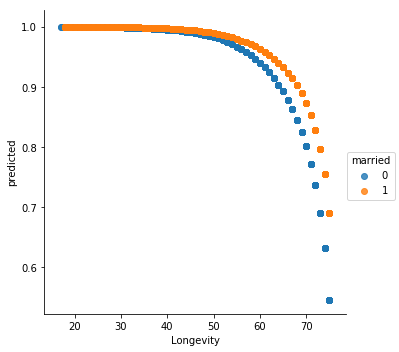

In [16]:
#graph predicted survived
data4=data3[(data3['Longevity'].notnull()) & (data3['married'].notnull()) & (data3['dead'].notnull())]
data4["predicted"] = rslt.predict(pred_type='surv').predicted_values

print(data3.head())

sns.lmplot(x="Longevity", y="predicted", hue="married", data=data4,fit_reg=False,lowess=True)
plt.show()
